In [1]:
### Ingestion step A
# -------------------------------

#add libraries required for final project

import requests
import pandas as pd
import numpy as np
import os
import sqlite3
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plotnine import *


In [2]:
file_path = './Tbl1_01_CS_Plate.csv'

# open the file for reading and automatically close it when exiting the "with" block
with open(file_path, 'r') as file:
    
    df_plate = pd.read_csv(file)
        
#print(df_plate.head(5))

In [3]:
################################
### Do Not Edit, Just Run   ####
################################


def dataframe2CreateTable(dataFrame, tableName = "WHATS_MY_NAME",useFirstColumnAsPK=True):
    '''
    This function inspects a Panda Dataframe and converts it to 
    a SQL Create Table Statement String
    
    Arguments:
       dataFrame : a panda dataframe with column headers
       tableName : a valid SQL table name
       useFirstColumnAsPK : Use the first column as a primary key, default=True
    
    Returns : a Create Table tableName string
    '''
    createTableStmt = "CREATE TABLE {} (\n".format(tableName)  # used the format to splice in the table name 
    dtype2SQL = {'object' : 'TEXT', 'float64' : 'REAL', 'int64' : "INTEGER"}
    columnList = list(dataFrame)  # Replaced players from code with function variable
    
    for columnName in columnList:
        # NOTE: Some of the columns start with a number, this is not valid column naming
        # in most databases;  so the next four lines detect and fix
        if (columnName[0].isdigit()):
            sqlColumnName = "n"+columnName   # we will just prepend the letter 'n' (for number)
        else:
            sqlColumnName = columnName

        pandaType = str(dataFrame[columnName].dtype) # Note, we need to force the conversion of the type name to a string
        sqlDataTypeStr = dtype2SQL[pandaType]      # Then we look up the SQL type Desired
        createTableStmt += "\t{} {},\n".format(sqlColumnName, sqlDataTypeStr)
    # END OF FOR EACH COLUMN
    
    # Close off the Create Table Statement with the PK
    if (useFirstColumnAsPK):
        createTableStmt += "\tPRIMARY KEY({})\n".format(columnList[0])
    else: # replace last comma with a space, note it's minus 2 because -1 is the newline
                                          # This is the substring access 
                                          # see : https://docs.python.org/3/tutorial/introduction.html#strings
        createTableStmt = createTableStmt[:len(createTableStmt) -2] + "\n"
    createTableStmt += ");"
    
    return  createTableStmt
# ------- END OF dataframe2CreateTable

In [4]:
### Ingestion step C
# -------------------------------
## Step below take the information from the CSV dataframe and convert it into a database file

table_decl = dataframe2CreateTable(df_plate, 'plates', False)

databaseFilename = './cs_plate_data.db'

# This code removes the db file in case you re-run the cell
if os.path.exists(databaseFilename):
    os.remove(databaseFilename)
    
# Open / Create the database file.
connection = sqlite3.connect(databaseFilename)

# SQLite uses a cursor to track and manage group operations.
cursor = connection.cursor()

# Create table
cursor.execute(table_decl)

# Save (commit) the changes
connection.commit()

# Close the connection
connection.close()

connection = sqlite3.connect(databaseFilename)

# Select the list of tables from the SQLite Engine Catalog for the database file
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Iterate through all the rows back, where the first column is the table name
for table_name in tables:
    print(table_name[0])

# Create a SQL string to insert the values
ncol = len(df_plate.columns)

# the question marks are placeholds that will be replace by the values
cmd = 'INSERT INTO plates VALUES({})'.format(','.join('?'*ncol))

for row in df_plate.itertuples(index=False, name=None):
    #The question marks in cmd will be replaced with the values in row
    # and the statement will be executed
    cursor.execute(cmd,row)

# Save (commit) the changes
connection.commit()

cur = connection.cursor()
cur.execute("SELECT * FROM plates limit 5;")

rows = cur.fetchall()

for row in rows:
    print(row)

plates
(1, 191167, 191167, 'Precontract', 'Plate - Carbon Steel (Non-sour)', '191167-MR-01302A', '191167 Outer Tank Bills Rev. C', '44.000 m Dia x 45.552 m HT Ethylene Tank (46.105k m3)', 1, 'MT', 1.0, 'Girder Plate3 ~ Horz', 16.0, 2128.0, 6936.0, 'A537 CL1', '191167-000-PS-SP-00003', 'Hyundai', 'USD', 1.0, '4/13/21', 'South Korea', 'South Korea', 'CFR', 'Saudi Arabia', 15.0, 16.0, 2128.0, 6936.0, 1.0, 1059.0, 76.0, 0.0, 120.0, 0, 0, 0, 0, 0.0, 0, 1.853831885, 1.853831885, 1059.0, 76.0, 0.0, 120.0, 1963.21, 140.89, 0.0, 222.46, 2021, 'Apr', 'Qtr2', 44.0, 45.552, 'Ethylene')
(2, 191167, 191167, 'Precontract', 'Plate - Carbon Steel (Non-sour)', '191167-MR-01302A', '191167 Outer Tank Bills Rev. C', '44.000 m Dia x 45.552 m HT Ethylene Tank (46.105k m3)', 1, 'MT', 1.0, 'Special Girder2 ~ Vert', 16.0, 702.0, 7100.0, 'A537 CL1', '191167-000-PS-SP-00003', 'Hyundai', 'USD', 1.0, '4/13/21', 'South Korea', 'South Korea', 'CFR', 'Saudi Arabia', 15.0, 16.0, 1500.0, 7100.0, 1.0, 1079.0, 76.0, 0.0, 

In [5]:
#pull in database from Task 1 and convert to a DataFrame for use in the analysis

connection2 = sqlite3.connect('cs_plate_data.db')

df_plate = pd.read_sql_query("SELECT * FROM plates", connection2)

# there is a column named 'id' and 'date' we want to delete from the dataframe
del df_plate['ID']

df_plate['Vendor_Ton_per_Tank_MT'] = df_plate['Vendor_Line_Tonnage_MT'] / df_plate['Number_of_Tanks']

df_plate.head()


,Project_number,Sub_CSS_Number,Contract_Type,Package_Description,MR_Number,MTO_Name,Tank_Design,Number_of_Tanks,UOM,Engg_Qty_Per_Tank_EA,...,BP_Line_USD,Fab_Line_USD,Freight_Line_USD,Year,Month,Quarters,Tank_Dia_m,Tank_Ht_m,Type_of_Tank,Vendor_Ton_per_Tank_MT
0,191167,191167,Precontract,Plate - Carbon Steel (Non-sour),191167-MR-01302A,191167 Outer Tank Bills Rev. C,44.000 m Dia x 45.552 m HT Ethylene Tank (46.1...,1,MT,1.0,...,140.89,0.0,222.46,2021,Apr,Qtr2,44.0,45.552,Ethylene,1.853832
1,191167,191167,Precontract,Plate - Carbon Steel (Non-sour),191167-MR-01302A,191167 Outer Tank Bills Rev. C,44.000 m Dia x 45.552 m HT Ethylene Tank (46.1...,1,MT,1.0,...,101.66,0.0,160.52,2021,Apr,Qtr2,44.0,45.552,Ethylene,1.337640
2,191167,191167,Precontract,Plate - Carbon Steel (Non-sour),191167-MR-01302A,191167 Outer Tank Bills Rev. C,44.000 m Dia x 45.552 m HT Ethylene Tank (46.1...,1,MT,1.0,...,98.98,0.0,156.29,2021,Apr,Qtr2,44.0,45.552,Ethylene,1.302409
3,191167,191167,Precontract,Plate - Carbon Steel (Non-sour),191167-MR-01302A,191167 Outer Tank Bills Rev. C,44.000 m Dia x 45.552 m HT Ethylene Tank (46.1...,1,MT,1.0,...,52.08,0.0,82.24,2021,Apr,Qtr2,44.0,45.552,Ethylene,0.685305
4,191167,251428,Precontract,Plate - Carbon Steel (Non-sour),251428-MR-01302A,251428 Sphere Plate List,21.50 m Dia Sphere (Ethylene),3,MT,2.0,...,15022.37,0.0,23719.54,2021,Apr,Qtr2,21.5,0.000,Sphere,65.887607


In [6]:
df_pricing = df_plate.groupby(['Project_number','Sub_CSS_Number','Contract_Type','Material_Grade','Vendor',
                               'Year','Quarters','Point_of_Manufacture'])['Vendor_Line_Tonnage_MT','Matl_Line_USD',
                                'BP_Line_USD', 'Fab_Line_USD','Freight_Line_USD'].sum()

df_pricing = df_pricing.reset_index() 

df_pricing['Matl_USD/MT'] = df_pricing['Matl_Line_USD']/df_pricing['Vendor_Line_Tonnage_MT']
df_pricing['period'] = df_pricing['Year'].astype(str) + " " + df_pricing['Quarters']

pd.options.display.float_format = '{:,.2f}'.format

df_pricing.head()


,Project_number,Sub_CSS_Number,Contract_Type,Material_Grade,Vendor,Year,Quarters,Point_of_Manufacture,Vendor_Line_Tonnage_MT,Matl_Line_USD,BP_Line_USD,Fab_Line_USD,Freight_Line_USD,Matl_USD/MT,period
0,179308,179308,Precontract,A36,Plate Solutions,2017,Qtr1,South Africa,"2,038.79","1,618,248.30","308,891.00","467,051.55","116,550.00",793.73,2017 Qtr1
1,182160,182160,Precontract,A516-70N,Posco,2016,Qtr4,South Korea,474.07,"333,241.87","37,694.30",0.00,"30,814.49",702.94,2016 Qtr4
2,182228,182228,Precontract,A36,Hyundai,2019,Qtr2,South Korea,"5,211.49","3,581,276.30","113,354.27","420,435.31","792,474.97",687.19,2019 Qtr2
3,182228,182228,Precontract,A537 CL1,Hyundai,2019,Qtr2,South Korea,21.93,"27,412.20",0.00,0.00,"1,052.63","1,250.00",2019 Qtr2
4,182228,182228,Precontract,A572-50,Hyundai,2019,Qtr2,South Korea,84.66,"59,398.21",0.00,0.00,"4,910.43",701.59,2019 Qtr2


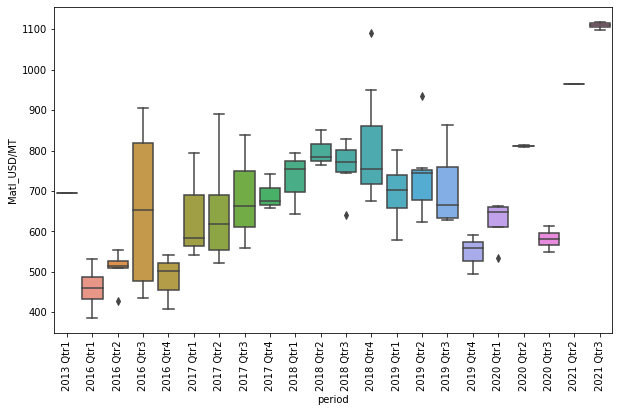

In [7]:
df_a36 = df_pricing[df_pricing['Material_Grade'] == "A36"]

df_a36 = df_a36.sort_values(['period'])

plt.figure(figsize=(10,6))
a36 = sbn.boxplot(x="period", y="Matl_USD/MT", data=df_a36)
a36 = a36.set_xticklabels(a36.get_xticklabels(), rotation=90)

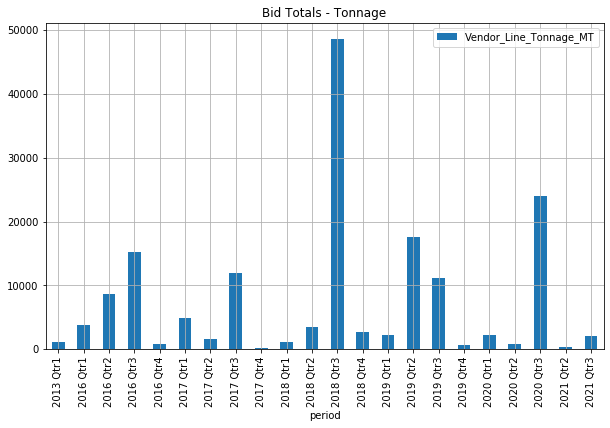

In [8]:
ton_a36 = df_a36[['Vendor_Line_Tonnage_MT','period']]   # Subset the columns of the dataframe
ton_a36_group = ton_a36.groupby('period')        # Define groups by name
ton_totals = ton_a36_group.sum()               # Sum ext price by name

my_plot = ton_totals.plot.bar(stacked=True,title="Bid Totals - Tonnage",figsize=(10, 6), grid=True)


Text(0.5, 1.0, 'South Korea A36 Price Variation')

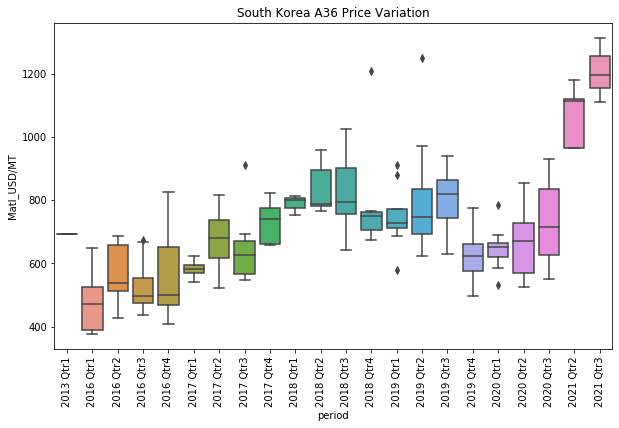

In [9]:
df_a36 = df_pricing[df_pricing['Material_Grade'] == "A36"]
df_a36 = df_pricing[df_pricing['Point_of_Manufacture'] == "South Korea"]

df_a36 = df_a36.sort_values(['period'])

plt.figure(figsize=(10,6))
a36 = sbn.boxplot(x="period", y="Matl_USD/MT", data=df_a36)
a36 = a36.set_xticklabels(a36.get_xticklabels(), rotation=90)
plt.title("South Korea A36 Price Variation")

In [10]:
df_dia = df_plate.groupby(['Project_number','Sub_CSS_Number','Contract_Type','Number_of_Tanks','Material_Grade','Vendor','Type_of_Tank',
                               'Year','Quarters','Point_of_Manufacture','Tank_Dia_m','Tank_Ht_m'])['Vendor_Ton_per_Tank_MT',
                                'Vendor_Line_Tonnage_MT', 'Matl_Line_USD','BP_Line_USD','Fab_Line_USD','Freight_Line_USD'].sum()

df_dia = df_dia.reset_index()

df_dia['dia_group'] = ""
df_dia['ht_group'] = ""

conditions1 = [(df_dia['Tank_Dia_m']<=5.5), #1
               (df_dia['Tank_Dia_m']<= 10), #2
               (df_dia['Tank_Dia_m']<= 15), #3
               (df_dia['Tank_Dia_m']<= 20), #4
               (df_dia['Tank_Dia_m']<= 30), #5
               (df_dia['Tank_Dia_m']<= 40), #6
               (df_dia['Tank_Dia_m']<= 50),
               (df_dia['Tank_Dia_m']<= 60),
               (df_dia['Tank_Dia_m']<= 70),
               (df_dia['Tank_Dia_m']<= 80),
               (df_dia['Tank_Dia_m']<= 90),
               (df_dia['Tank_Dia_m']<= 100),
               (df_dia['Tank_Dia_m']<= 120),
               (df_dia['Tank_Dia_m'] > 120)]

values1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

df_dia['dia_group'] = np.select(conditions1, values1)

conditions2 = [(df_dia['Tank_Ht_m']<=5.5), #1
               (df_dia['Tank_Ht_m']<= 10), #2
               (df_dia['Tank_Ht_m']<= 15), #3
               (df_dia['Tank_Ht_m']<= 20), #4
               (df_dia['Tank_Ht_m']<= 30), #5
               (df_dia['Tank_Ht_m']<= 40), #6
               (df_dia['Tank_Ht_m']<= 50),
               (df_dia['Tank_Ht_m']<= 60),
               (df_dia['Tank_Ht_m']<= 70),
               (df_dia['Tank_Ht_m']<= 80),
               (df_dia['Tank_Ht_m']<= 90),
               (df_dia['Tank_Ht_m']<= 100),
               (df_dia['Tank_Ht_m']<= 120),
               (df_dia['Tank_Ht_m'] > 120)]

values2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

df_dia['ht_group'] = np.select(conditions2, values2)

df_dia.head()

,Project_number,Sub_CSS_Number,Contract_Type,Number_of_Tanks,Material_Grade,Vendor,Type_of_Tank,Year,Quarters,Point_of_Manufacture,Tank_Dia_m,Tank_Ht_m,Vendor_Ton_per_Tank_MT,Vendor_Line_Tonnage_MT,Matl_Line_USD,BP_Line_USD,Fab_Line_USD,Freight_Line_USD,dia_group,ht_group
0,179308,179308,Precontract,1,A36,Plate Solutions,AGDR,2017,Qtr1,South Africa,36.80,20.00,384.16,384.16,"302,230.73","55,177.46","86,258.53","21,898.56",6,4
1,179308,179308,Precontract,1,A36,Plate Solutions,DRT,2017,Qtr1,South Africa,16.00,12.50,75.69,75.69,"64,947.86","16,240.46","20,110.92","4,325.45",4,3
2,179308,179308,Precontract,2,A36,Plate Solutions,AGDR,2017,Qtr1,South Africa,26.20,20.00,213.22,426.44,"344,377.55","71,940.74","101,906.44","24,630.34",5,4
3,179308,179308,Precontract,3,A36,Plate Solutions,AGDR,2017,Qtr1,South Africa,36.80,20.00,384.16,"1,152.49","906,692.16","165,532.34","258,775.66","65,695.65",6,4
4,182160,182160,Precontract,1,A516-70N,Posco,CRT,2016,Qtr4,South Korea,4.00,4.90,9.85,9.85,"7,383.48",828.71,0.00,640.30,1,1


In [11]:
df_dia.dia_group.cov(df_dia.ht_group)

2.3039797466536207

In [12]:
df_dia.dia_group.corr(df_dia.ht_group)

0.5206265592286752

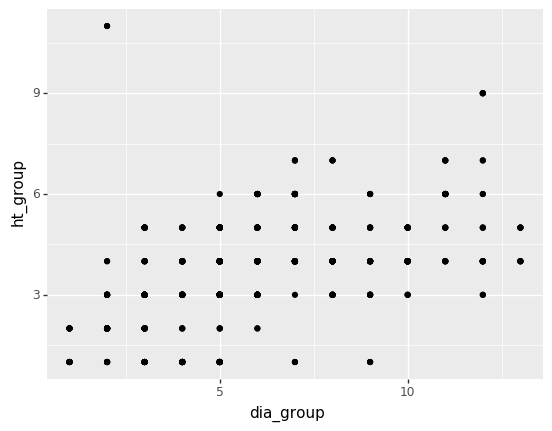

<ggplot: (-9223363276453325894)>

In [13]:
ggplot(aes(x='dia_group', y = 'ht_group'), data = df_dia) + geom_point()

In [14]:
df_dia2 = df_dia[df_dia['Type_of_Tank'] == "DRT"]

df_dia2 = df_dia2.groupby(['Contract_Type','Type_of_Tank',
                            'Tank_Dia_m','Tank_Ht_m','dia_group','ht_group'])['Vendor_Ton_per_Tank_MT','Matl_Line_USD'].sum()

df_dia2 = df_dia2.reset_index()

df_dia2['Dia_Ht'] = df_dia2['dia_group'].astype(str) + "-" + df_dia2['ht_group'].astype(str)

df_dia2 = df_dia2.sort_values(['Dia_Ht'])

df_dia2.head()

,Contract_Type,Type_of_Tank,Tank_Dia_m,Tank_Ht_m,dia_group,ht_group,Vendor_Ton_per_Tank_MT,Matl_Line_USD,Dia_Ht
1,Precontract,DRT,5.00,5.00,1,1,13.42,"9,602.19",1-1
0,Precontract,DRT,4.57,6.10,1,2,16.70,"9,455.30",1-2
2,Precontract,DRT,6.60,6.40,2,2,39.55,"28,160.32",2-2
3,Precontract,DRT,8.00,9.00,2,2,30.65,"14,512.93",2-2
4,Precontract,DRT,8.00,10.00,2,2,56.48,"62,123.00",2-2


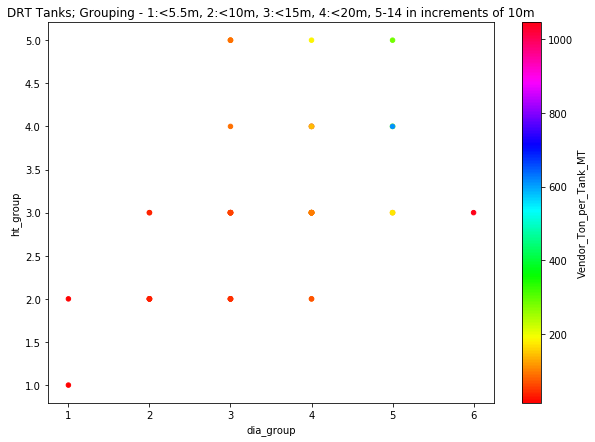

In [15]:
df_dia2.plot(kind="scatter", x="dia_group", y="ht_group", c="Vendor_Ton_per_Tank_MT", cmap=cm.hsv, 
             sharex = False, figsize=(10,7))
plt.title("DRT Tanks; Grouping - 1:<5.5m, 2:<10m, 3:<15m, 4:<20m, 5-14 in increments of 10m")
plt.show()

,Dia_Ht
4-3,13
3-3,8
4-4,6
3-2,5
2-2,5
5-4,3
3-5,3
5-3,3
2-3,2
4-2,2


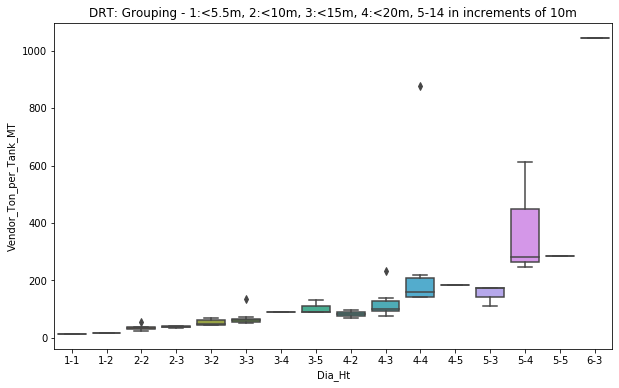

In [17]:
plt.figure(figsize=(10,6))
dia_comp = sbn.boxplot(x="Dia_Ht", y="Vendor_Ton_per_Tank_MT", data=df_dia2)
plt.title("DRT: Grouping - 1:<5.5m, 2:<10m, 3:<15m, 4:<20m, 5-14 in increments of 10m")
df_dia2['Dia_Ht'].value_counts().to_frame()
